<a href="https://colab.research.google.com/github/inagib21/StockForecastingLSTM/blob/main/Amazon_Stock_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stock price forecasting is a popular application of deep learning models like Long Short-Term Memory (LSTM) networks. LSTM is a type of recurrent neural network (RNN) that is capable of learning long-term dependencies and capturing sequential patterns in the data.

In [1]:
#import libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('AMZN.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
2,1997-05-22,0.071875,0.072396,0.065625,0.069792,0.069792,235536000
3,1997-05-23,0.070313,0.076042,0.066667,0.075000,0.075000,318744000
4,1997-05-27,0.075521,0.082292,0.072917,0.079167,0.079167,173952000
...,...,...,...,...,...,...,...
6544,2023-05-22,116.769997,116.769997,114.250000,115.010002,115.010002,70741100
6545,2023-05-23,114.269997,117.139999,113.779999,114.989998,114.989998,67576300
6546,2023-05-24,115.349998,117.339996,115.019997,116.750000,116.750000,63487900
6547,2023-05-25,116.629997,116.870003,114.309998,115.000000,115.000000,66496700


for this analysis all we will use is the closing date

In [2]:

data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-20,0.081771
1,1997-05-21,0.071354
2,1997-05-22,0.069792
3,1997-05-23,0.075000
4,1997-05-27,0.079167
...,...,...
6544,2023-05-22,115.010002
6545,2023-05-23,114.989998
6546,2023-05-24,116.750000
6547,2023-05-25,115.000000


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

<ipython-input-4-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


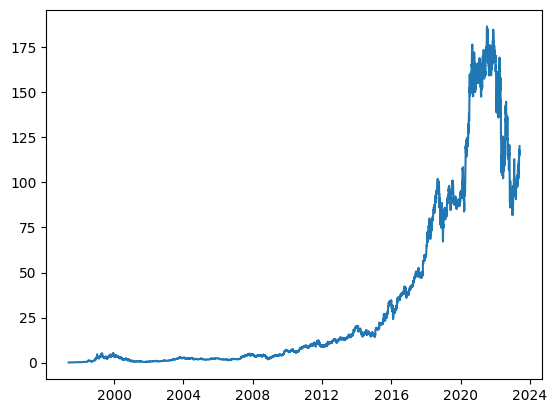

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [5]:
from copy import deepcopy as dc

# Function to prepare the DataFrame for LSTM-based forecasting
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)  # Create a deep copy of the input DataFrame
    
    df.set_index('Date', inplace=True)  # Set the 'Date' column as the index
    
    # Iterate over the previous time steps
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)  # Create new columns with shifted closing prices
        
    df.dropna(inplace=True)  # Remove rows with missing values (NaN)
    
    return df  # Return the preprocessed DataFrame

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df


,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
1997-06-03,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792
1997-06-04,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000
1997-06-05,0.077083,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167
...,...,...,...,...,...,...,...,...
2023-05-22,115.010002,116.250000,118.150002,115.500000,113.400002,111.199997,110.260002,112.180000
2023-05-23,114.989998,115.010002,116.250000,118.150002,115.500000,113.400002,111.199997,110.260002
2023-05-24,116.750000,114.989998,115.010002,116.250000,118.150002,115.500000,113.400002,111.199997


In [6]:
# Convert the shifted DataFrame to a NumPy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np


array([[7.50000000e-02, 7.52600000e-02, 7.65630000e-02, ...,
        6.97920000e-02, 7.13540000e-02, 8.17710000e-02],
       [7.55210000e-02, 7.50000000e-02, 7.52600000e-02, ...,
        7.50000000e-02, 6.97920000e-02, 7.13540000e-02],
       [7.39580000e-02, 7.55210000e-02, 7.50000000e-02, ...,
        7.91670000e-02, 7.50000000e-02, 6.97920000e-02],
       ...,
       [1.16750000e+02, 1.14989998e+02, 1.15010002e+02, ...,
        1.15500000e+02, 1.13400002e+02, 1.11199997e+02],
       [1.15000000e+02, 1.16750000e+02, 1.14989998e+02, ...,
        1.18150002e+02, 1.15500000e+02, 1.13400002e+02],
       [1.20110001e+02, 1.15000000e+02, 1.16750000e+02, ...,
        1.16250000e+02, 1.18150002e+02, 1.15500000e+02]])

In [7]:
#viewing dimensions of our df
shifted_df_as_np.shape

(6542, 8)

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of the MinMaxScaler with a feature range of (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Apply the scaling transformation to the shifted DataFrame as a NumPy array
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np


array([[-0.99995531, -0.99995253, -0.99993855, ..., -1.        ,
        -0.99998325, -0.99987154],
       [-0.99994973, -0.99995531, -0.99995253, ..., -0.99994415,
        -1.        , -0.99998325],
       [-0.99996649, -0.99994973, -0.99995531, ..., -0.99989946,
        -0.99994415, -1.        ],
       ...,
       [ 0.25125338,  0.23237933,  0.23259385, ...,  0.23785279,
         0.21533279,  0.19174033],
       [ 0.23248659,  0.25125338,  0.23237933, ...,  0.26627093,
         0.23785279,  0.21533279],
       [ 0.28728563,  0.23248659,  0.25125338, ...,  0.24589565,
         0.26627093,  0.23785279]])

In [9]:
# Split the shifted array into input features (X) and target variable (y)
X = shifted_df_as_np[:, 1:]  # All columns except the first column (closing price at t)
y = shifted_df_as_np[:, 0]   # First column (closing price at t)

# Display the shape of X and y
X.shape, y.shape


((6542, 7), (6542,))

In [10]:
# Create a deep copy of the array X and reverse the order of columns
X = dc(np.flip(X, axis=1))
X

array([[-0.99987154, -0.99998325, -1.        , ..., -0.99991063,
        -0.99993855, -0.99995253],
       [-0.99998325, -1.        , -0.99994415, ..., -0.99993855,
        -0.99995253, -0.99995531],
       [-1.        , -0.99994415, -0.99989946, ..., -0.99995253,
        -0.99995531, -0.99994973],
       ...,
       [ 0.19174033,  0.21533279,  0.23785279, ...,  0.24589144,
         0.23259385,  0.23237933],
       [ 0.21533279,  0.23785279,  0.26627093, ...,  0.23259385,
         0.23237933,  0.25125338],
       [ 0.23785279,  0.26627093,  0.24589565, ...,  0.23237933,
         0.25125338,  0.23248659]])

In [11]:
# Calculate the index to split the data into training and testing sets
split_index = int(len(X) * 0.95)

split_index

6214

In [12]:
# Split the data into training and testing sets
X_train = X[:split_index]   # First split_index rows for training
X_test = X[split_index:]    # Remaining rows for testing

y_train = y[:split_index]   # First split_index elements for training
y_test = y[split_index:]    # Remaining elements for testing

# Display the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((6214, 7), (328, 7), (6214,), (328,))

In [13]:
# Reshape the training and testing sets to match the expected input shape for LSTM
X_train = X_train.reshape((-1, lookback, 1))   # Reshape X_train to (number of samples, lookback, 1)
X_test = X_test.reshape((-1, lookback, 1))     # Reshape X_test to (number of samples, lookback, 1)

y_train = y_train.reshape((-1, 1))             # Reshape y_train to (number of samples, 1)
y_test = y_test.reshape((-1, 1))               # Reshape y_test to (number of samples, 1)

# Display the shapes of the reshaped arrays
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((6214, 7, 1), (328, 7, 1), (6214, 1), (328, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6214, 7, 1]),
 torch.Size([328, 7, 1]),
 torch.Size([6214, 1]),
 torch.Size([328, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.853
Batch 200, Loss: 0.463
Batch 300, Loss: 0.199

Val Loss: 0.042
***************************************************

Epoch: 2
Batch 100, Loss: 0.018
Batch 200, Loss: 0.013
Batch 300, Loss: 0.008

Val Loss: 0.014
***************************************************

Epoch: 3
Batch 100, Loss: 0.005
Batch 200, Loss: 0.004
Batch 300, Loss: 0.002

Val Loss: 0.010
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.006
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.004
*****************

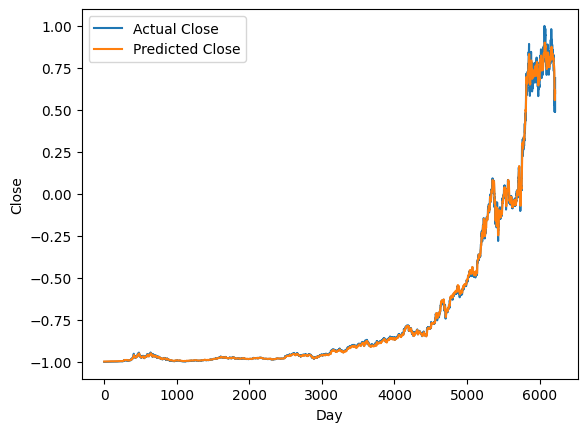

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.29651503,   0.29660952,   0.29664842, ..., 149.51051535,
       151.03479726, 149.29543822])

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.50015923e-02, 7.55184978e-02, 7.39566652e-02, ...,
       1.50612502e+02, 1.38845505e+02, 1.57639498e+02])

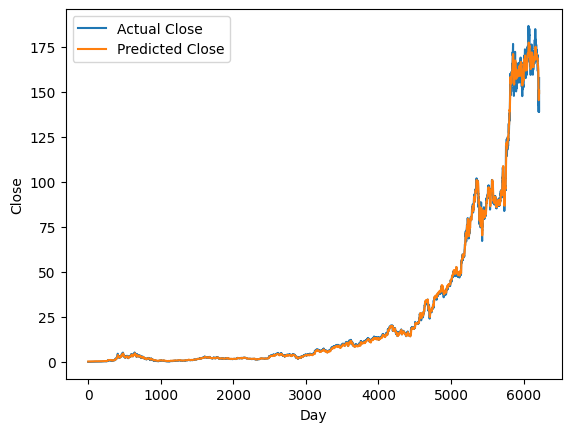

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([152.0972436 , 154.77907134, 157.43155219, 159.26830066,
       160.09371528, 159.41282297, 159.37473871, 159.13331608,
       159.34650345, 158.76051053, 157.77653933, 156.46628407,
       154.25624649, 153.89657479, 154.40958955, 154.85586237,
       154.75130852, 154.84064423, 154.0061254 , 152.80127994,
       149.48958346, 146.16605374, 144.51293454, 145.60999132,
       146.48695198, 146.33104107, 147.52882215, 150.15997092,
       153.26630586, 156.4364036 , 158.69283482, 161.00436928,
       162.57925234, 163.5567928 , 164.31359795, 165.53847489,
       166.51915568, 166.73781224, 166.12710791, 165.68226909,
       166.19783503, 165.95334987, 164.55344208, 163.10224949,
       161.34372605, 159.25270456, 157.4510612 , 157.04427329,
       156.21098836, 155.89165195, 156.89871716, 157.03093379,
       155.79743065, 153.67406645, 152.16628661, 149.47811706,
       146.85705628, 146.4811493 , 140.94204611, 136.12101908,
       132.40085058, 130.32430801, 126.15033544, 122.31

In [28]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([157.93550165, 161.41349717, 161.18949925, 159.003495  ,
       153.29350176, 155.1670061 , 156.51049894, 158.10049453,
       154.6524962 , 152.60149876, 150.19749381, 144.82699629,
       151.35800212, 153.78849709, 153.56300403, 151.14199678,
       152.05250627, 147.89849848, 145.64100565, 137.45300383,
       136.01449488, 139.27900567, 146.81750468, 145.52450739,
       141.8529947 , 147.36650272, 153.10400311, 157.23899657,
       161.25050521, 161.49149987, 164.8890082 , 163.4080074 ,
       163.64950785, 164.77349929, 168.99049174, 169.31500275,
       166.30099379, 162.99749555, 163.55999984, 168.34649425,
       164.05499516, 158.75599734, 157.78449856, 154.4604964 ,
       151.1219931 , 150.78750525, 155.54100108, 151.70649644,
       152.78500575, 158.11549591, 153.99799942, 148.29600432,
       144.35000372, 146.07400567, 139.39100462, 138.16700588,
       144.59649537, 124.2815027 , 124.50000086, 124.25350088,
       125.92849685, 116.40699847, 114.77249899, 108.78

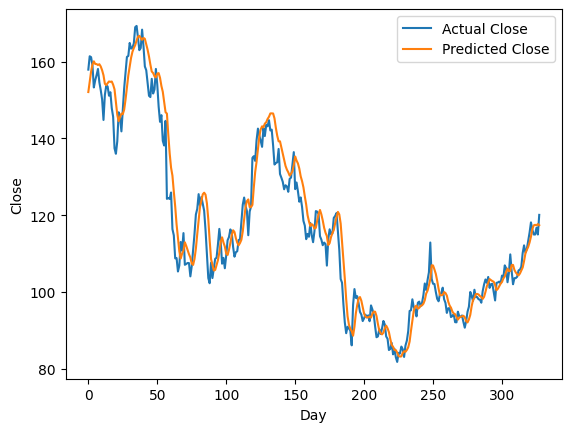

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
